# Ajuste de Oultiers
El presente notebook presenta un algoritmo para suavizar outliers en series temporales de variables atmósfericas. Se trabaja con los valores obtenidos por una red inalámbrica de sensores desplegada en un cultivo de cacao en una vereda del municipio de San Cayetano, Norte de Santander. Las mediciones analizadas corresponden a las variables atmósfericas Temperatura, Humedad Relativa, Humedad de la Tierra e Intensidad Lumínica.

In [1]:
# Se importan los módulos necesarios
import pandas as pd
import matplotlib.pylab as plt
from matplotlib import cm
import seaborn as sns
import funs
from scipy.stats.stats import pearsonr

# Se define un límite para las filas de los dataframes que se presenten en el notebook
pd.options.display.max_rows = 10

In [18]:
# Importa los datos correspondientes al nodo 2
nodo = 5
mediciones_cacao = pd.read_csv('mediciones_cacao_n%s.csv' %nodo)
#mediciones_cacao.loc[:, 'TIME'] = [pd.Timestamp(x) for x in mediciones_cacao['TIME']]
mediciones_cacao.drop('NIVEL UV',axis=1,inplace=True)
mediciones_cacao = mediciones_cacao.head(20000).copy()
# Crea dos copias de los datos, filtrado para realzar un filtro de valores atípicos
# según el rango de medición y ajustado para suavizar la curva 
filtrado = mediciones_cacao.copy()
ajustado = mediciones_cacao.copy()

In [19]:
mediciones_cacao

,TEMPERATURA,HUMEDAD RELATIVA,HUMEDAD DE LA TIERRA,INTENSIDAD LUMÍNICA,HORA,TIME
0,30,58,80.42,5829,10,2018-05-09 10:25:00
1,30,57,73.20,5829,10,2018-05-09 10:26:00
2,30,57,67.75,5841,10,2018-05-09 10:27:00
3,30,57,63.25,5824,10,2018-05-09 10:28:00
4,30,56,58.92,5835,10,2018-05-09 10:29:00
...,...,...,...,...,...,...
11766,33,29,6.59,5865,6,2018-06-11 06:13:00
11767,33,29,6.43,5865,6,2018-06-11 06:14:00
11768,33,29,6.43,5865,6,2018-06-11 06:15:00
11769,33,29,6.43,5865,6,2018-06-11 06:16:00


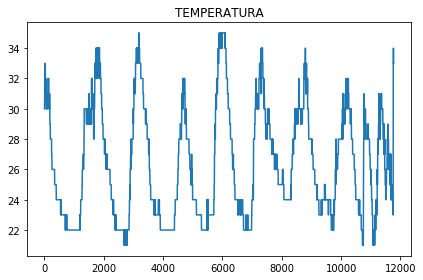

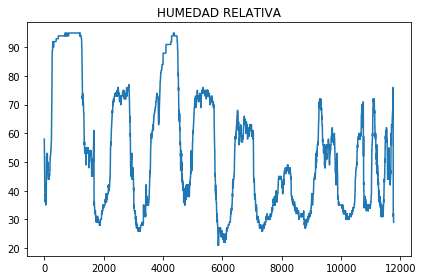

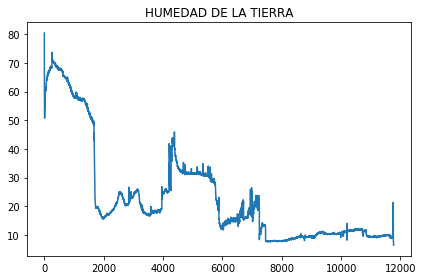

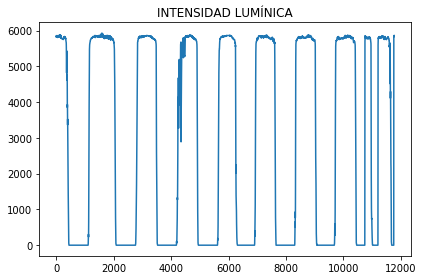

In [20]:
# Grafica las variables  de interes
a=510
for i in range(0,4):
    a+=1
    #plt.subplot(a)
    plt.figure()
    plt.plot(mediciones_cacao.iloc[:,i])
    plt.title(mediciones_cacao.columns[i])
    plt.tight_layout()


A partir de los gráficos de los valores medidos es posible deducir relaciones existentes entre las variables:
- Relación de proporcionaliad inversa entre la temperatura y la humedad relativa.
- Correlación positiva entre la humedad relativa y la humedad del suelo.
- Correspodencia de los valores máximos de intensidad lumínica con los ciclos positivos de temperatura.

Correlaciones positivas
- Temperatura - Intensidad Lumínica.
- Humedad Relativa - Humedad de la Tierra.

Correlaciones negativas
- Temperatura - Humedad Relativa
- Temperatura - Humedad de la Tierra.
- Humedad Relativa - Intensidad Lumínica.

A continuación se realiza un grafico de matriz de correlación para visualizar mejor la relación entre las varibles.

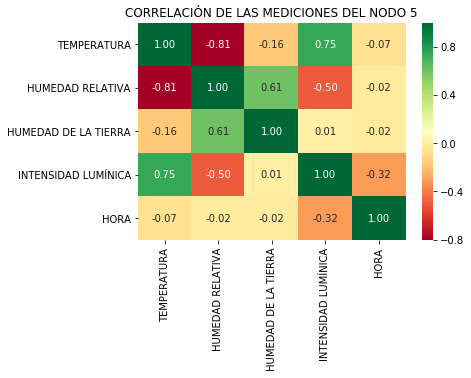

In [21]:
sns.heatmap(mediciones_cacao.corr(), annot=True, cmap='RdYlGn',fmt=".2f")
plt.title('CORRELACIÓN DE LAS MEDICIONES DEL NODO %s' %nodo)
plt.show()

Se aplica un filtro para ajustar el rango de valores medidos de las variables, variando el mismo desde un límite máximo basado en el rango de medida del sensor, hasta el rango definido por el criterio de Tukey para los valores de la variable. Finalmente se selecciona el rango que garantice la mejor correlación entre las variables.

In [22]:
def info_var(v):
    'Grafica todos los valores medidos para la variable v'
    variable = mediciones_cacao.columns[v]
    
    plt.plot(mediciones_cacao[variable],'orange',label='datos')
    plt.title(variable)
    plt.legend()
    
def tukey(variable):
    'Obtiene los límites superiores e inferiores para v'
    
    RIQ = variable.quantile(q=.75) - variable.quantile(q=.25)
    Li = variable.quantile(q=.25) - RIQ * 1.5
    Ls = variable.quantile(q=.75) + RIQ * 1.5
    return Li, Ls

In [23]:
def filtro(variable,i,q):
    'Iguala el valor de una medición a un determinado valor límite'
    global filtrado
    
    try:
        filtrado[variable][i] = filtrado[variable][i-120:i].median()   
        
    except KeyError:
        filtrado[variable][i]= q
    return

def filtro_var(v,lim_i,lim_s):
    'Ajusta los valores atípicos en las mediciones de la variable v'
    
    global filtrado,filtrar
    variable=filtrado.columns[v]
    Li, Ls = tukey(filtrado[variable])

    for i in range(len(filtrado[variable])):
              
        if filtrado[variable][i] >= lim_s:
            filtro(variable,i,filtrado[variable].quantile(.75))
        
        elif filtrado[variable][i] <= lim_i:
            filtro(variable,i,filtrado[variable].quantile(.25))
            
        elif filtrado[variable][i] >= Ls and Ls > lim_s:
            filtro(variable,i,filtrado[variable].quantile(.75))
            
        elif filtrado[variable][i] <= Li and Li < lim_i:
            filtro(variable,i,filtrado[variable].quantile(.25))
    return filtrado.corr()

In [24]:
def up_ajuste(filtrado,v):
    global ajustado
    variable=ajustado.columns[v]
    ajustado[variable]=filtrado[variable].copy()
    return

def ajuste_variacion(v):
    'Ajusta los valores que presentan una variación superior a la std'
    global ajustado
    up_ajuste(filtrado,v)
    variable=ajustado.columns[v]
    ventana=60
    rolling_std = ajustado[variable].rolling(ventana).std()
    rolling_std_inv=ajustado[variable].iloc[::-1].rolling(ventana).std().iloc[::-1]
    indice=rolling_std[rolling_std.isnull().values].index
    rolling_std[indice[0]]=rolling_std_inv[indice[0]]

    nvalores=ajustado[variable][rolling_std>(rolling_std.mean())].index.values
    rolling_median=ajustado[variable].rolling(ventana).median()
    rolling_median_inv=ajustado[variable].iloc[::-1].rolling(ventana).median().iloc[::-1]
    indice=rolling_median[rolling_median.isnull().values].index
    rolling_median[indice[0]]=rolling_median_inv[indice[0]]
    suave=ajustado[variable].copy()
    suave[nvalores]=rolling_median[nvalores+ventana]
    plt.figure()
    plt.plot(filtrado[variable],label='filtrado')
    plt.plot(suave,label='suavizado')
    plt.legend()
    ajustado[variable]=suave
    return         

In [ ]:
def val_ranngo(Li,lim_i,lim_s,var,var_rel)         
    'Determia la columna de correlación entre dos variables'
    global mediciones_cacao
    correl={'corre':[]}
    for rango in range(int(Li),lim_i):
        # Eto se puede  variar y que filtro var devuelva el indice de correlación de Pearson
        filtrado = mediciones_cacao.copy()
        # Aplcación del filtro de rango
        corre = filtro_var(v,rango,lim_s)
        correl['corre'].append(corre.iloc[var,var_rel])
    return

In [ ]:
def recorrido(var,var_rel): 
    if Li>lim_i:
        print('Li mayor')
        correl={'corre':[]}
        # ciclo for para variar el rango desde el límite inferior hasta el límite de Tukey
        for rango in range(lim_i,int(Li)):
            # Eto se puede  variar y que filtro var devuelva el indice de correlación de Pearson
            filtrado = mediciones_cacao.copy()
            # Aplcación del filtro de rango
            corre = filtro_var(v,rango,lim_s)
            correl['corre'].append(corre.iloc[var,var_rel])
    else:
        print('else')
        # ciclo for para variar el rango desde el límite inferior hasta el límite de Tukey
        correl={'corre':[]}
        for rango in range(int(Li),lim_i):
            # Eto se puede  variar y que filtro var devuelva el indice de correlación de Pearson
            filtrado = mediciones_cacao.copy()
            # Aplcación del filtro de rango
            corre = filtro_var(v,rango,lim_s)
            correl['corre'].append(corre.iloc[var,var_rel])
            
    correl=pd.DataFrame(correl)
    # Devuelve el límite infeior más cercano al límite de Tukey con menor correlación
    menor = correl.index[correl['corre'] == correl.corre.min()].tolist()[-1]

In [30]:
def filtro_rango(v,lim_i,lim_s):
    global mediciones_cacao
    
    variable = mediciones_cacao.columns[v]
    
    # Se realiza el test de Tukey
    Li, Ls = tukey(mediciones_cacao[variable])
    print(Li)
    # se verifica si el límite inferior de Tukey es mayor que el límite inferior de medida
    if Li>lim_i:
        print('Li mayor')
        # ciclo for para variar el rango desde el límite inferior hasta el límite de Tukey
        for rango in range(lim_i,int(Li)):
            # Eto se puede  variar y que filtro var devuelva el indice de correlación de Pearson
            filtrado = mediciones_cacao.copy()
            # Aplcación del filtro de rango
            corr = filtro_var(v,rango,lim_s)
            print(corr)
    else:
        print('else')
        # ciclo for para variar el rango desde el límite inferior hasta el límite de Tukey
        correl={'corre':[]}
        for rango in range(int(Li),lim_i):
            # Eto se puede  variar y que filtro var devuelva el indice de correlación de Pearson
            filtrado = mediciones_cacao.copy()
            # Aplcación del filtro de rango
            corre = filtro_var(v,rango,lim_s)
            correl['corre'].append(corre.iloc[0,1])
    correl=pd.DataFrame(correl)
    # Devuelve el límite infeior más cercano al límite de Tukey con menor correlación
    menor = correl.index[correl['corre'] == correl.corre.min()].tolist()[-1]
    print('menor',menor)
    Li=int(Li)+menor+1
        
    return Li
        

filtrado = mediciones_cacao.copy()
a=filtro_rango(1,16,55)
a

-21.5
else


C:\Users\Jergb\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Jergb\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


menor 36


16

Temperatura 0
HR 1
HS 2
IL 3
H 4
correlación--->(X,X)

In [28]:
filtro_var(0,0,50)

,TEMPERATURA,HUMEDAD RELATIVA,HUMEDAD DE LA TIERRA,INTENSIDAD LUMÍNICA,HORA
TEMPERATURA,1.000000,-0.619261,-0.160006,0.748181,-0.067127
HUMEDAD RELATIVA,-0.619261,1.000000,0.440134,-0.439747,0.099167
HUMEDAD DE LA TIERRA,-0.160006,0.440134,1.000000,0.011778,-0.021691
INTENSIDAD LUMÍNICA,0.748181,-0.439747,0.011778,1.000000,-0.316369
HORA,-0.067127,0.099167,-0.021691,-0.316369,1.000000


In [ ]:
a={'corre':[3,5,2,2,1]}
a=pd.DataFrame(a)
a.index[a['corre'] == a.corre.min()].tolist()[0]
#pd.DataFrame(d)
#d[0]

In [ ]:
Debe variar los límites y escoger el rango que asegure la mejor correación, luego pasa a trabajar con otra variable 
y repite el paso anterior, así hasta completar todas las variables, luego vuelve a comenzar, se realiza hasa que todas 
las variables presentan el valor de correlación más óptimo.
def filter():
# calcular la correlación entre la variable de ineres y las demás
# variar el límte superior hasta llegar al valor dspuesto por tukey para el límite superior, seleccioar el valor superior
#que ofrece la mejor correlación con las demás variables. VAriar el límite inferior......
# pasar a la sigiente variable.....
# Repetir hasta opbtner los mejores valores

# Se hace de manera ana´loga para suavizar la serie

El sensor DHT11 tiene rangos de medición de:  
- Temperatura de $(20°C - 50°C)\pm5°C$  
- Humedad Ralativa de $(20\% - 90\%)\pm2\%$

L arelación entre la temperatura y la humedad relativa es de una correlación negativa


In [ ]:
(mediciones_cacao.iloc[:,1:2]).boxplot()
plt.figure()

info_var(1)
filtro_var(1,0,54)
ajuste_variacion(1)

plt.figure()

(ajustado.iloc[:,1:2]).boxplot()
filtrado.corr().iloc[:,0:1]

In [ ]:
plt.scatter(mediciones_cacao.iloc[:,1],mediciones_cacao.iloc[:,2])
plt.figure()
plt.hist(mediciones_cacao.iloc[:,1])
plt.hist(mediciones_cacao.iloc[:,2])
plt.show()

In [ ]:
info_var(1)
filtro_var(1,0,54)
ajuste_variacion(1)
plt.figure()
plt.plot(mediciones_cacao.iloc[:,1].rolling(60).std())

In [ ]:
info_var(2)
filtro_var(2,10,100)
ajuste_variacion(2)
plt.figure()
plt.plot(mediciones_cacao.iloc[:,2].rolling(60).std())

In [ ]:
-1<3


In [ ]:
info_var(3)
filtro_var(3,0,100)
ajuste_variacion(3)
plt.figure()
plt.plot(mediciones_cacao.iloc[:,3].rolling(60).std())

In [ ]:
info_var(4)
filtro_var(4,-10,6000)
ajuste_variacion(4)
plt.figure()
plt.plot(mediciones_cacao.iloc[:,4].rolling(60).std())

In [ ]:
mediciones_cacao['NODO'].replace(to_replace=[nodo], value='Nodo%s'%nodo, inplace=True) 
sns.pairplot(mediciones_cacao,hue='NODO',plot_kws=dict(s=10),diag_kind='kde')
plt.show()

In [ ]:
ajustado['NODO'].replace(to_replace=[nodo], value='Nodo%s' %nodo, inplace=True) 
sns.pairplot(ajustado,hue='NODO',plot_kws=dict(s=10),diag_kind=('kde'))
plt.show()

In [ ]:
filtrado['NODO'].replace(to_replace=[nodo], value='Nodo%s' %nodo, inplace=True) 

sns.heatmap(mediciones_cacao.corr(), annot=True, cmap='RdYlGn',fmt=".2f")
plt.title('CORRELACIÓN DE LAS MEDICIONES DEL NODO %s' %nodo)
plt.figure()
sns.heatmap(filtrado.corr(), annot=True, cmap='RdYlGn',fmt=".2f")
plt.title('MEDICIONES FILTRADAS DEL NODO %s' %nodo)
plt.figure()
sns.heatmap(ajustado.corr(), annot=True, cmap='RdYlGn',fmt=".2f")
plt.title('MEDICIONES AJUSTADAS DEL NODO %s' %nodo)
plt.show()